# Bank Customer Churn Prediction.

### About dataset:
**The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer. The dataset includes the following attributes:**

1. Customer ID: A unique identifier for each customer

2. Surname: The customer's surname or last name

3. Credit Score: A numerical value representing the customer's credit score

4. Geography: The country where the customer resides (France, Spain or Germany)

5. Gender: The customer's gender (Male or Female)

6. Age: The customer's age.

7. Tenure: The number of years the customer has been with the bank

8. Balance: The customer's account balance

9. NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)

10. HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)

11. IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)

12. EstimatedSalary: The estimated salary of the customer

13. Exited: Whether the customer has churned (1 = yes, 0 = no)




## Import necessary libraries

In [2]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

### Read dataset

In [61]:
# Import dataset
churn_df = pd.read_csv(r"/content/drive/MyDrive/Colab_Notebooks/Bank_Churn_Prediction/Churn_Modelling.csv")
churn_df.head() ## head fuction are showing top 5 rows data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
## check the dataset shape
churn_df.shape

(10002, 14)

In [63]:
## remove the unwanted columns

churn_df.drop(['RowNumber','CustomerId','Surname'], axis=1, inplace=True)

In [64]:
# check the columns
churn_df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [65]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10002 non-null  int64  
 1   Geography        10001 non-null  object 
 2   Gender           10002 non-null  object 
 3   Age              10001 non-null  float64
 4   Tenure           10002 non-null  int64  
 5   Balance          10002 non-null  float64
 6   NumOfProducts    10002 non-null  int64  
 7   HasCrCard        10001 non-null  float64
 8   IsActiveMember   10001 non-null  float64
 9   EstimatedSalary  10002 non-null  float64
 10  Exited           10002 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 859.7+ KB


In [66]:
# Check for missing values
churn_df.isnull().sum()

CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [67]:
null_values = ['Geography', 'Age', 'HasCrCard', 'IsActiveMember']
for null in null_values:
    churn_df[null].fillna(churn_df[null].mode()[0], inplace = True)

In [68]:
# checking the duplicated values in data
churn_df.duplicated().sum()

2

In [69]:
# remove the duplicate values
churn_df = churn_df.drop_duplicates()
churn_df.duplicated().sum()

0

In [70]:
# drop rows with null values
churn_df.dropna(inplace=True)

In [71]:
# Summary statistics
churn_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.922903,10.487128,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


### EDA and Visualization

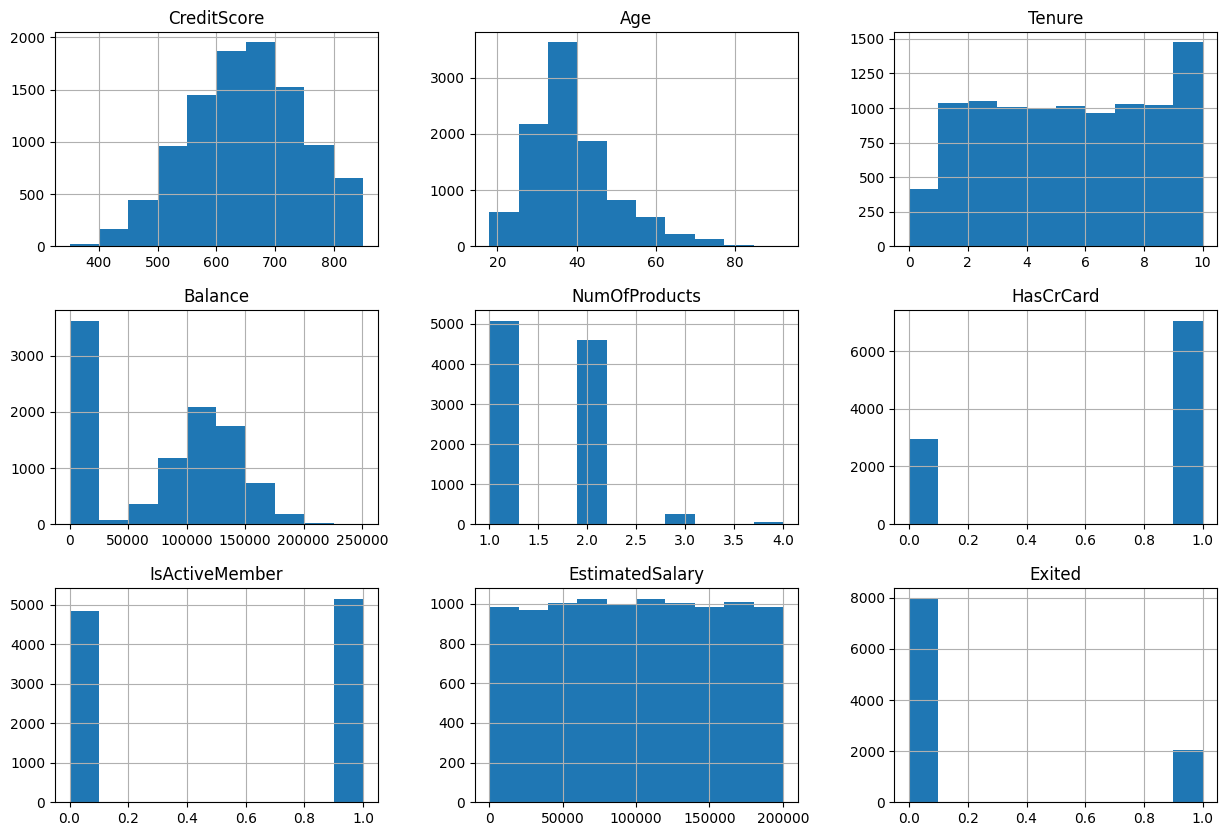

In [16]:
# Plot histogram of numerical values
churn_df.hist(figsize=(15, 10))
plt.show()

0    7963
1    2037
Name: Exited, dtype: int64


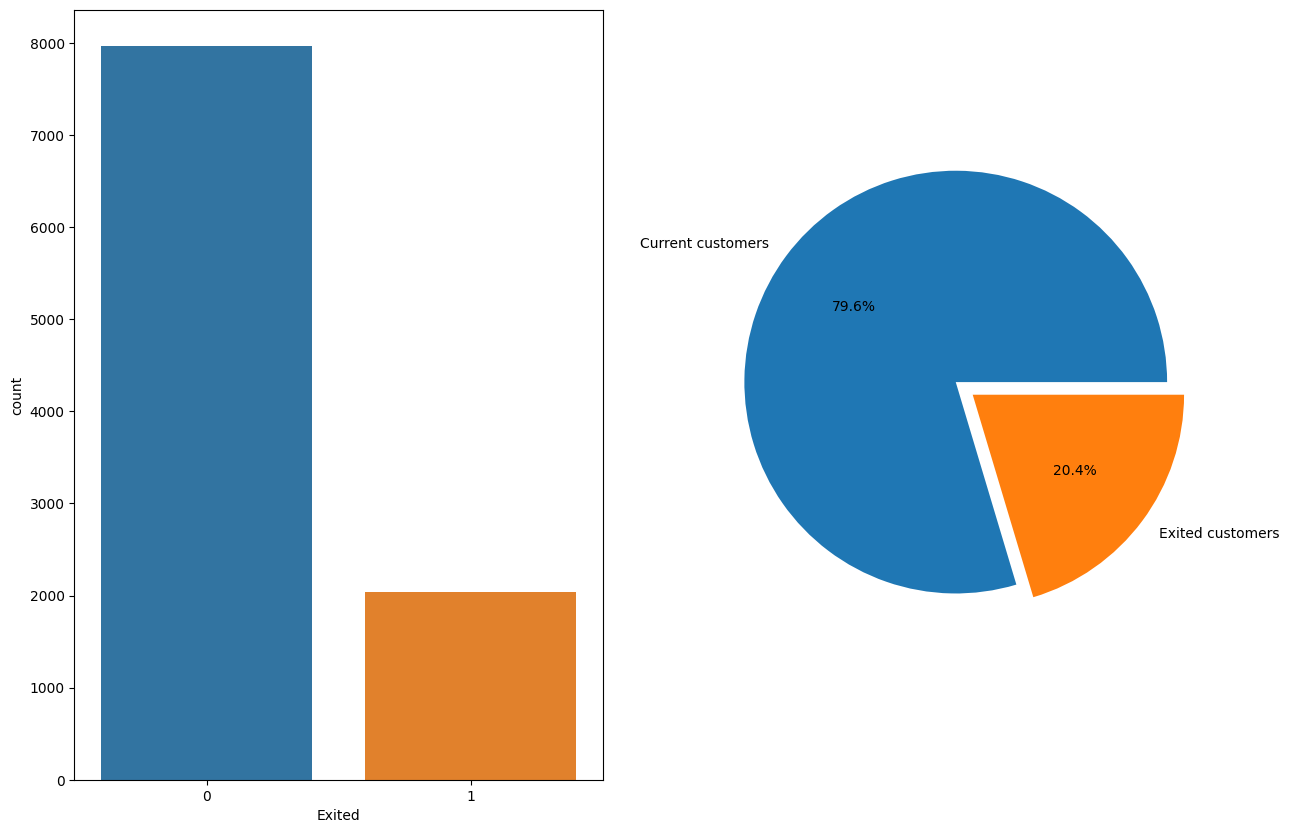

In [17]:
# Analyzing the distribution of target variable
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
sns.countplot(x=churn_df['Exited'])

plt.subplot(1, 2, 2)
explode = [0.1,0.0]
labels = ['Current customers', 'Exited customers']
plt.pie(churn_df['Exited'].value_counts(), explode=explode, labels=labels, autopct='%.01f%%')
print(churn_df['Exited']. value_counts())

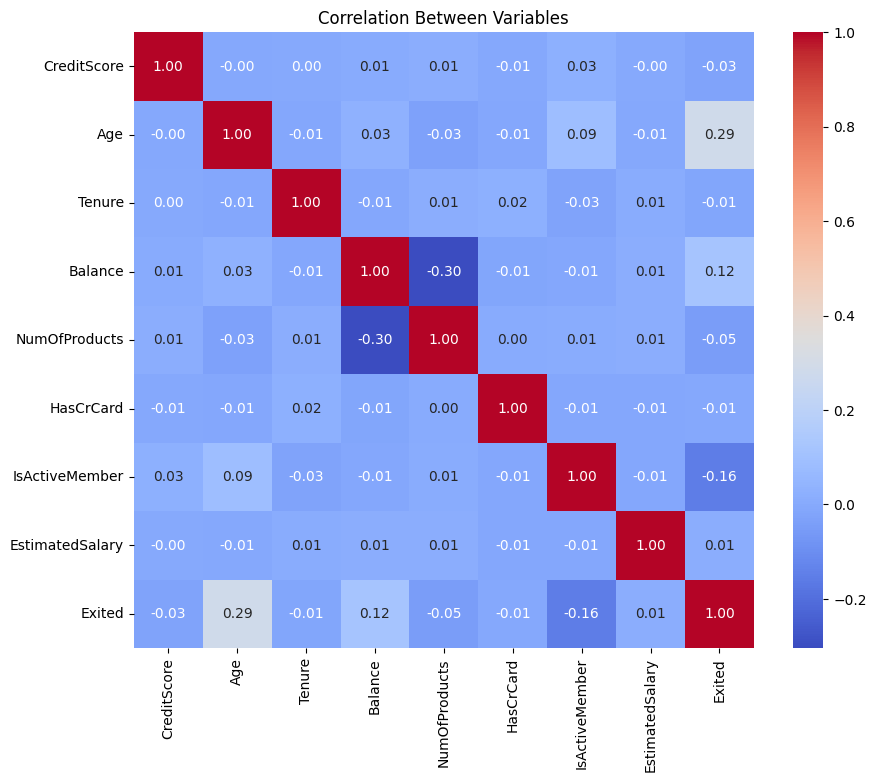

In [18]:
# Correlation between variables
plt.figure(figsize=(10, 8))
sns.heatmap(churn_df.corr(), cmap='coolwarm', annot=True, fmt = '.2f')
plt.title('Correlation Between Variables')
plt.show();

### Encoding Categorical Data

In [19]:
# churn_df = pd.get_dummies(churn_df, columns=['Geography', 'Gender'])

In [72]:
from sklearn.preprocessing import LabelEncoder
cat_var = ['Geography', 'Gender']

cat_dict = {}
for col in cat_var:
    le = LabelEncoder()
    churn_df[col] = le.fit_transform(churn_df[col])
    col_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    cat_dict[col] = col_mapping

In [73]:
cat_dict

{'Geography': {'France': 0, 'Germany': 1, 'Spain': 2},
 'Gender': {'Female': 0, 'Male': 1}}

In [30]:
churn_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42.0,2,0.00,1,1,1,101348.88,1
1,608,2,0,41.0,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42.0,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39.0,1,0.00,2,0,0,93826.63,0
4,850,2,0,43.0,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,1,39.0,5,0.00,2,1,0,96270.64,0
9996,516,0,1,35.0,10,57369.61,1,1,1,101699.77,0
9997,709,0,0,36.0,7,0.00,1,0,1,42085.58,1
9998,772,1,1,42.0,3,75075.31,2,1,0,92888.52,1


In [29]:
churn_df['IsActiveMember'] = churn_df['IsActiveMember'].astype(int)
churn_df['HasCrCard'] = churn_df['HasCrCard'].astype(int)

### Handling Imbalanced Data using SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) is a popular technique used to address class imbalance in machine learning. In our dataset, the number of instances in the minority class (`Churned`) is much smaller than the number of instances in the majority class (`Retained`). This can lead to poor performance of machine learning models, as they tend to be biased towards the majority class.

The basic idea behind SMOTE is to create new minority class samples by randomly selecting one or more of the k-nearest neighbors of each minority class sample, and using them to create new synthetic samples.

In [31]:
# Preprocess data
X = churn_df.drop('Exited', axis=1)
y = churn_df['Exited']

In [32]:
# # Oversampling using SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [33]:
y_resampled.value_counts()

1    7963
0    7963
Name: Exited, dtype: int64

### Splitting the dataset into training and test sets

In [34]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, random_state=42)

# Scaling numerical variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (12740, 10)
y_train shape: (12740,)
X_test shape: (3186, 10)
y_test shape: (3186,)


## Model Building, Selection and Evaluation:
Model building involves choosing an appropriate machine learning algorithm and evaluating its performance on the dataset. We built different algorithms, such as
- Logistic Regression,
- KNeighbors
- Decision Tree
- Random Forest,
- XGBoost and
- Support Vector Machines,

and compared their metrics.

In [35]:
# # Scale the features
# scaler = StandardScaler()
# X_train_resampled_scaled = scaler.fit_transform(X_resampled)
# X_test_scaled = scaler.transform(X_test)

# Model training and Evaluation
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

In [36]:
# Initialize empty DataFrame to store results
results_df = pd.DataFrame(
    columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'AUC-ROC']
)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    results_df = results_df.append(
        {'Model': name,
         'Accuracy': accuracy,
         'F1 Score': f1,
         'Precision': precision,
         'Recall': recall,
         'AUC-ROC': roc_auc}, ignore_index=True
    )
# Print results DataFrame
results_df

,Model,Accuracy,F1 Score,Precision,Recall,AUC-ROC
0,Logistic Regression,0.774325,0.773258,0.757726,0.789440,0.774695
1,K-Nearest Neighbors,0.827370,0.826717,0.809377,0.844816,0.827797
2,Decision Tree,0.826114,0.826005,0.806254,0.846748,0.826620
3,Random Forest,0.877589,0.874356,0.874919,0.873793,0.877496
4,Support Vector Machine,0.849341,0.846351,0.841502,0.851256,0.849388
5,XGBoost,0.903327,0.898950,0.916388,0.882164,0.902809


Based on the results, the Random Forrest model has the highest scores in all the performance metrics, followed by the XGBoost model.

### Hyperparameter tuning for RandomForest model

In [37]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create random forest model and perform grid search
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [38]:
# Print best hyperparameters and corresponding F1 score
print('Best Hyperparameters:', grid_search.best_params_)
y_pred = grid_search.predict(X_test)
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# Evaluate model using accuracy
rf_model = RandomForestClassifier(random_state=42, **grid_search.best_params_)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
F1 Score: 0.8745198463508324
Accuracy: 0.8769617074701821


The reported best hyperparameters are `{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}`, meaning that these values have been found to give the best performance for the model.

The model's performance is better when the `F1 score` and `Accuracy` are higher. In this case, the `F1 score` is 90.8% and the `Accuracy` is 91.2%.

### Save the Model

In [39]:
from joblib import dump, load

# Train and save RandomForest Classifier model
X_resampled = scaler.fit_transform(X_resampled)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

dump(rf_model, 'churn_rf_model.joblib')

['churn_rf_model.joblib']

In [40]:
# Load saved logistic regression model
rf_model = load('churn_rf_model.joblib')

# Use loaded model to make predictions
y_pred = rf_model.predict(X_test)

## Encoding Creation

In [86]:
# Create an encoding for the has credict card and the is active column
x = {'HasCrCard': {'Yes': 1, "No" : 0},
'IsActiveMember': {'Yes': 1, "No" : 0}}
x

{'HasCrCard': {'Yes': 1, 'No': 0}, 'IsActiveMember': {'Yes': 1, 'No': 0}}

In [85]:
# Merge the two encodings together
from collections import ChainMap
cat_dict = ChainMap(cat_dict, x)

In [78]:
cat_dict

ChainMap({'Geography': {'France': 0, 'Germany': 1, 'Spain': 2}, 'Gender': {'Female': 0, 'Male': 1}}, {'HasCrCard': {'Yes': 1, 'No': 0}, 'IsActiveMember': {'Yes': 1, 'No': 0}})

In [79]:
# Import the pickle file
import pickle

In [81]:
with open('cat_dict.json', 'wb') as fp: # Save the categorical encodings to aid deployment of the model
     pickle.dump(cat_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [82]:
cat_dict

ChainMap({'Geography': {'France': 0, 'Germany': 1, 'Spain': 2}, 'Gender': {'Female': 0, 'Male': 1}}, {'HasCrCard': {'Yes': 1, 'No': 0}, 'IsActiveMember': {'Yes': 1, 'No': 0}})

In [83]:
# Load

with open(r'cat_dict.json', 'rb') as fp:
    f = pickle.load(fp)

In [84]:
f

ChainMap({'Geography': {'France': 0, 'Germany': 1, 'Spain': 2}, 'Gender': {'Female': 0, 'Male': 1}}, {'HasCrCard': {'Yes': 1, 'No': 0}, 'IsActiveMember': {'Yes': 1, 'No': 0}})

### Feature Importance

We create a function to visualize the feature importance. The purpose of this function is to visualize the feature importances of a machine learning model which can provide insights into which features are most important for predicting the target variable.